In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from tqdm import tqdm
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
LEVEL_TO_INDEX = {
    'A2_0': 0,
    'B1_1': 1,
    'B1_2': 2,
    'B2_0': 3
}

def load_texts_and_labels(folder_path):
    texts = []
    labels = []
    count = 0  # Initialize a counter
    for filename in os.listdir(folder_path):
        if filename.endswith('.txt'):
            # Extract Level from filename (e.g., SM_CHN_PTJ1_146_B1_1.txt)
            level = '_'.join(filename.split('_')[-2:]).replace('.txt', '')  # Extract B1_1
            if level not in LEVEL_TO_INDEX:
                print(f"Skipping file {filename} due to unknown level {level}")
                continue
            label_index = LEVEL_TO_INDEX[level]

            # Read File Content
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(label_index)
                count += 1  # Increment the counter
                if count >= 4000:  # Break if 4000 samples are loaded
                    break

    return texts, labels

# Example Usage
#folder_path = '/content/drive/MyDrive/CULI_project/SM_0_Unclassified_Unmerged'
folder_path = '/content/drive/MyDrive/SM_0_Unclassified_Unmerged'
texts, labels = load_texts_and_labels(folder_path)

print(f"Loaded {len(texts)} samples.")
print("Example:", texts[0][:100], "Label Index:", labels[0])

Skipping file SM_ENS_SMK1_114_XX_1.txt due to unknown level XX_1
Skipping file SM_ENS_PTJ1_140_XX_1.txt due to unknown level XX_1
Skipping file SM_ENS_PTJ1_145_XX_3.txt due to unknown level XX_3
Skipping file SM_ENS_PTJ2_112_XX_3.txt due to unknown level XX_3
Skipping file SM_ENS_PTJ2_106_XX_3.txt due to unknown level XX_3
Skipping file SM_ENS_SMK1_145_XX_3.txt due to unknown level XX_3
Skipping file SM_ENS_PTJ2_107_XX_1.txt due to unknown level XX_1
Skipping file SM_ENS_PTJ2_123_XX_2.txt due to unknown level XX_2
Skipping file SM_ENS_PTJ1_080_XX_2.txt due to unknown level XX_2
Skipping file SM_ENS_PTJ1_107_XX_1.txt due to unknown level XX_1
Skipping file SM_ENS_PTJ1_137_XX_1.txt due to unknown level XX_1
Skipping file SM_ENS_PTJ2_120_XX_3.txt due to unknown level XX_3
Skipping file SM_ENS_PTJ2_100_XX_2.txt due to unknown level XX_2
Skipping file SM_ENS_SMK1_087_XX_2.txt due to unknown level XX_2
Skipping file SM_ENS_PTJ1_147_XX_1.txt due to unknown level XX_1
Skipping file SM_ENS_PTJ1

In [6]:
total_length = 0
for text in texts:
    total_length += len(text)

mean_length = total_length / len(texts)
print(f"Mean length of texts: {mean_length:.2f}")

Mean length of texts: 566.66


In [7]:
text_series = pd.Series(texts)
text_lengths = text_series.apply(len)
mean_length_pd = text_lengths.mean()

In [8]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        # Removed max_length from here as we're not doing fixed padding/truncation

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        # Tokenize without fixed max_length padding/truncation
        encoding = self.tokenizer(
            self.texts[idx],
            # padding='max_length', # Removed
            truncation=True, # Still good to truncate if very long for model limits
            # max_length=self.max_length, # Removed
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Custom collate function to pad sequences within a batch
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = torch.stack([item['label'] for item in batch])

    # Pad input_ids and attention_mask to the maximum length in the current batch
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0) # Assuming padding value 0 for attention mask

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'label': labels
    }


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Pass only texts, labels, and tokenizer to the dataset
dataset = TextDataset(texts, labels, tokenizer)

# Use the custom collate_fn with the DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# Code to check the implementation (shapes will now vary based on batch max length)
print("Checking shapes of individual items from the dataset:")
for i in range(min(5, len(dataset))): # Check first 5 items or fewer if dataset is small
    item = dataset[i]
    print(f"Item {i}:")
    print("  Input IDs shape:", item['input_ids'].shape)
    print("  Attention Mask shape:", item['attention_mask'].shape)
    print("  Label shape:", item['label'].shape)

print("\nChecking shapes of a batch from the dataloader:")
for batch in dataloader:
    print("Input IDs shape:", batch['input_ids'].shape)
    print("Attention Mask shape:", batch['attention_mask'].shape)
    print("Label shape:", batch['label'])
    break # Just check one batch

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Checking shapes of individual items from the dataset:
Item 0:
  Input IDs shape: torch.Size([144])
  Attention Mask shape: torch.Size([144])
  Label shape: torch.Size([])
Item 1:
  Input IDs shape: torch.Size([110])
  Attention Mask shape: torch.Size([110])
  Label shape: torch.Size([])
Item 2:
  Input IDs shape: torch.Size([95])
  Attention Mask shape: torch.Size([95])
  Label shape: torch.Size([])
Item 3:
  Input IDs shape: torch.Size([32])
  Attention Mask shape: torch.Size([32])
  Label shape: torch.Size([])
Item 4:
  Input IDs shape: torch.Size([42])
  Attention Mask shape: torch.Size([42])
  Label shape: torch.Size([])

Checking shapes of a batch from the dataloader:
Input IDs shape: torch.Size([8, 167])
Attention Mask shape: torch.Size([8, 167])
Label shape: tensor([2, 1, 3, 2, 3, 2, 1, 1])


In [13]:
from sklearn.model_selection import train_test_split

# Split into training and a temporary set (validation + test)
# Use test_size=0.2 to leave 80% for training
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts,
    labels,
    test_size=0.10,  # 20% for validation + test
    random_state=42,
    stratify=labels  # Ensures equal class distribution
)

# Split the temporary set into validation and test sets
# Use test_size=0.5 to split the 20% temp set into 10% validation and 10% test
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,  # Half of 20% = 10% test
    random_state=42,
    stratify=temp_labels  # Maintains balance in val/test
)

print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")
print(f"Test samples: {len(test_texts)}")

Training samples: 3420
Validation samples: 190
Test samples: 190


In [14]:
train_dataset = TextDataset(train_texts, train_labels, tokenizer)
val_dataset = TextDataset(val_texts, val_labels, tokenizer)
test_dataset = TextDataset(test_texts, test_labels, tokenizer)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 3420
Validation dataset size: 190
Test dataset size: 190


In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

print(f"Number of batches in training dataloader: {len(train_dataloader)}")
print(f"Number of batches in validation dataloader: {len(val_dataloader)}")
print(f"Number of batches in test dataloader: {len(test_dataloader)}")

Number of batches in training dataloader: 428
Number of batches in validation dataloader: 24
Number of batches in test dataloader: 24


In [21]:
class PrototypicalNet(nn.Module):
    def __init__(self, num_classes=4, embed_dim=256, num_prototypes=3, similarity='cosine'):
        super(PrototypicalNet, self).__init__()
        self.encoder = BertModel.from_pretrained('bert-base-uncased')
        self.encoder_dim = self.encoder.config.hidden_size  # BERT output size (768)
        self.num_classes = num_classes
        self.num_prototypes = num_prototypes
        self.embed_dim = embed_dim  # Final embedding dimension (256)
        self.similarity = similarity

        # MLP to reduce BERT output to embed_dim
        self.mlp = nn.Sequential(
            nn.Linear(self.encoder.config.hidden_size, embed_dim),
            nn.GELU(),
            nn.LayerNorm(embed_dim)
        )

        self.prototypes = nn.Parameter(torch.randn(num_classes, num_prototypes, 256))
        if similarity == 'cosine':
            self.s = nn.Parameter(torch.tensor(10.0))
            self.b = nn.Parameter(torch.tensor(0.0))
            self.temp = nn.Parameter(torch.tensor(1.0))  # Temperature scaling

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state.mean(dim=1)  # [B, encoder_dim]
        x = self.mlp(x)  # [B, embed_dim]

        if self.similarity == 'cosine':
            x_norm = F.normalize(x, p=2, dim=-1)  # [B, embed_dim]
            p_norm = F.normalize(self.prototypes, p=2, dim=-1)  # [C, K, embed_dim]
            x_exp = x_norm.unsqueeze(1).unsqueeze(2)  # [B, 1, 1, embed_dim]
            p_exp = p_norm.unsqueeze(0)               # [1, C, K, embed_dim]
            sim = (x_exp * p_exp).sum(dim=-1)         # [B, C, K]
            sim = sim.mean(dim=2)                     # [B, C]
            logits = (self.s * sim + self.b) / self.temp  # [B, C]

        elif self.similarity == 'euclidean':
            dist = ((x.unsqueeze(1).unsqueeze(2) - self.prototypes.unsqueeze(0)) ** 2).sum(-1)  # [B, C, K]
            sim = -dist.mean(dim=2)  # [B, C]
            logits = sim

        return logits, x

    def init_prototypes(self, dataloader, labels):
        """Initialize prototypes using KMeans clustering per class"""
        from sklearn.cluster import KMeans
        embeddings = []

        with torch.no_grad():
            for batch in dataloader:
                input_ids = batch['input_ids'].to(next(self.parameters()).device)
                attention_mask = batch['attention_mask'].to(next(self.parameters()).device)
                outputs = self.encoder(input_ids, attention_mask)
                x = outputs.last_hidden_state.mean(1)
                x = self.mlp(x)
                embeddings.append(x.cpu())

        embeddings = torch.cat(embeddings)
        labels_tensor = torch.tensor(labels)

        for c in range(self.num_classes):
            class_embeddings = embeddings[labels_tensor == c]
            if len(class_embeddings) == 0:
                print(f"Warning: No samples found for class {c}. Initializing prototypes randomly.")
                self.prototypes.data[c] = torch.randn(self.num_prototypes, self.embed_dim).to(self.prototypes.device)
                continue

            n_clusters = min(self.num_prototypes, len(class_embeddings))
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            kmeans.fit(class_embeddings.numpy())

            prototypes_c = torch.zeros(self.num_prototypes, self.embed_dim)
            prototypes_c[:n_clusters] = torch.tensor(kmeans.cluster_centers_, dtype=prototypes_c.dtype)

            self.prototypes.data[c] = prototypes_c.to(self.prototypes.device)

In [22]:
def initialize_prototypes(model, dataloader, num_classes=4, num_prototypes=3):
    device = next(model.parameters()).device
    class_embeddings = [[] for _ in range(num_classes)]

    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Initializing Prototypes"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_batch = batch['label'].to(device)

            outputs = model.encoder(input_ids=input_ids, attention_mask=attention_mask)
            embeddings = outputs.last_hidden_state.mean(dim=1)  # [B, 768]
            embeddings = model.mlp(embeddings)  # <-- Project to [B, 256]

            for emb, label in zip(embeddings, labels_batch):
                class_embeddings[label.item()].append(emb)

    prototype_list = []
    for class_embeds in class_embeddings:
        class_embeds = torch.stack(class_embeds)
        if len(class_embeds) < num_prototypes:
            mean_embed = class_embeds.mean(dim=0, keepdim=True)
            padded = mean_embed.repeat(num_prototypes - len(class_embeds), 1)
            proto_class = torch.cat([class_embeds, padded], dim=0)
        else:
            indices = torch.randperm(len(class_embeds))[:num_prototypes]
            proto_class = class_embeds[indices]
        prototype_list.append(proto_class)

    model.prototypes.data = torch.stack(prototype_list).to(device)
    print(f"Prototypes shape after init: {model.prototypes.shape}")  # Should be [C, K, 256]

In [23]:
def compute_loss_weights(labels, num_classes, alpha=0.5, device='cpu'):
    # Count samples per class
    label_count = torch.zeros(num_classes)
    for label in labels:
        label_count[label] += 1

    label_count = label_count.float()
    label_count_pow = label_count.pow(alpha)
    lw_weights = label_count_pow / label_count_pow.sum()
    lw_weights = lw_weights / label_count  # The "re-weighted" loss weights
    lw_weights = lw_weights.to(device)

    return lw_weights

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = PrototypicalNet(num_classes=4, embed_dim=256).to(device)

# Initialize prototypes using the training data
# Note: After splitting data, you should use the train_dataloader here
initialize_prototypes(model, train_dataloader, num_classes=4)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)


lw_weights = compute_loss_weights(train_labels, num_classes=4, alpha=0.5, device=device)

criterion = nn.CrossEntropyLoss(weight=lw_weights)


train_losses = [] # List to store training loss per epoch


Initializing Prototypes:   0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Initializing Prototypes: 100%|██████████| 428/428 [00:42<00:00, 10.02it/s]

Prototypes shape after init: torch.Size([4, 3, 256])


In [25]:
from sklearn.metrics import accuracy_score

# Initialize lists to track metrics
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(15):
    # --- Training Phase ---
    model.train()
    total_train_loss = 0
    all_train_preds = []
    all_train_labels = []

    # Use the training dataloader
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_batch = batch['label'].to(device)

        optimizer.zero_grad()
        logits, _ = model(input_ids, attention_mask)

        # Handle potential batch size mismatches
        batch_size = logits.shape[0]
        labels_batch = labels_batch[:batch_size]

        loss = criterion(logits, labels_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

        # Store predictions and labels for accuracy calculation
        preds = torch.argmax(logits, dim=1)
        all_train_preds.extend(preds.cpu().numpy())
        all_train_labels.extend(labels_batch.cpu().numpy())

    # Calculate training metrics
    avg_train_loss = total_train_loss / len(train_dataloader)
    train_accuracy = accuracy_score(all_train_labels, all_train_preds) * 100
    train_losses.append(avg_train_loss)

    # --- Validation Phase ---
    model.eval()
    total_val_loss = 0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        # Use the validation dataloader
        for batch in tqdm(val_dataloader, desc=f"Epoch {epoch+1} Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_batch = batch['label'].to(device)

            logits, _ = model(input_ids, attention_mask)

            batch_size = logits.shape[0]
            labels_batch = labels_batch[:batch_size]

            loss = criterion(logits, labels_batch)
            total_val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_val_preds.extend(preds.cpu().numpy())
            all_val_labels.extend(labels_batch.cpu().numpy())

    # Calculate validation metrics
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_accuracy = accuracy_score(all_val_labels, all_val_preds) * 100
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Training Loss: {avg_train_loss:.4f} | Training Acc: {train_accuracy:.2f}%")
    print(f"  Validation Loss: {avg_val_loss:.4f} | Validation Acc: {val_accuracy:.2f}%\n")

Epoch 1 Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1 Validation: 100%|██████████| 24/24 [00:02<00:00, 10.06it/s]



Epoch 1 Summary:
  Training Loss: 1.2720 | Training Acc: 47.87%
  Validation Loss: 1.1802 | Validation Acc: 44.74%



Epoch 2 Training:   0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2 Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2 Validation: 100%|██████████| 24/24 [00:02<00:00, 10.73it/s]



Epoch 2 Summary:
  Training Loss: 1.0873 | Training Acc: 53.86%
  Validation Loss: 1.1754 | Validation Acc: 46.84%



Epoch 3 Training:   0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3 Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3 Validation: 100%|██████████| 24/24 [00:02<00:00, 10.64it/s]



Epoch 3 Summary:
  Training Loss: 0.8253 | Training Acc: 66.17%
  Validation Loss: 1.1874 | Validation Acc: 50.53%



Epoch 4 Training:   0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 4 Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 4 Validation: 100%|██████████| 24/24 [00:02<00:00, 10.16it/s]



Epoch 4 Summary:
  Training Loss: 0.5535 | Training Acc: 81.05%
  Validation Loss: 1.2626 | Validation Acc: 58.42%



Epoch 5 Training:   0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 5 Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 5 Validation: 100%|██████████| 24/24 [00:02<00:00, 10.72it/s]



Epoch 5 Summary:
  Training Loss: 0.4010 | Training Acc: 88.04%
  Validation Loss: 1.3755 | Validation Acc: 54.74%



Epoch 6 Training:   0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 6 Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 6 Validation: 100%|██████████| 24/24 [00:02<00:00, 10.75it/s]



Epoch 6 Summary:
  Training Loss: 0.2995 | Training Acc: 92.28%
  Validation Loss: 1.4900 | Validation Acc: 50.53%



Epoch 7 Training:   0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 7 Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 7 Validation: 100%|██████████| 24/24 [00:02<00:00,  9.97it/s]



Epoch 7 Summary:
  Training Loss: 0.2300 | Training Acc: 94.85%
  Validation Loss: 1.6747 | Validation Acc: 51.58%



Epoch 8 Training:   0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 8 Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 8 Validation: 100%|██████████| 24/24 [00:02<00:00, 10.76it/s]



Epoch 8 Summary:
  Training Loss: 0.2111 | Training Acc: 95.06%
  Validation Loss: 1.7265 | Validation Acc: 55.79%



Epoch 9 Training:   0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 9 Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 9 Validation: 100%|██████████| 24/24 [00:02<00:00, 10.73it/s]



Epoch 9 Summary:
  Training Loss: 0.1648 | Training Acc: 96.70%
  Validation Loss: 1.6440 | Validation Acc: 56.84%



Epoch 10 Training:   0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 10 Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 10 Validation: 100%|██████████| 24/24 [00:02<00:00, 10.26it/s]



Epoch 10 Summary:
  Training Loss: 0.1498 | Training Acc: 96.81%
  Validation Loss: 1.7393 | Validation Acc: 54.21%



Epoch 11 Training:   0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 11 Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 11 Validation: 100%|██████████| 24/24 [00:02<00:00, 10.70it/s]



Epoch 11 Summary:
  Training Loss: 0.1611 | Training Acc: 96.14%
  Validation Loss: 1.7424 | Validation Acc: 56.84%



Epoch 12 Training:   0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 12 Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 12 Validation: 100%|██████████| 24/24 [00:02<00:00, 10.77it/s]



Epoch 12 Summary:
  Training Loss: 0.1542 | Training Acc: 96.02%
  Validation Loss: 1.6546 | Validation Acc: 55.26%



Epoch 13 Training:   0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 13 Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 13 Validation: 100%|██████████| 24/24 [00:02<00:00, 10.31it/s]



Epoch 13 Summary:
  Training Loss: 0.1120 | Training Acc: 97.69%
  Validation Loss: 1.7284 | Validation Acc: 60.53%



Epoch 14 Training:   0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 14 Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 14 Validation: 100%|██████████| 24/24 [00:02<00:00, 10.68it/s]



Epoch 14 Summary:
  Training Loss: 0.1370 | Training Acc: 96.29%
  Validation Loss: 1.7336 | Validation Acc: 56.32%



Epoch 15 Training:   0%|          | 0/428 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 15 Validation:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 15 Validation: 100%|██████████| 24/24 [00:02<00:00, 10.72it/s]


Epoch 15 Summary:
  Training Loss: 0.1257 | Training Acc: 96.78%
  Validation Loss: 1.8200 | Validation Acc: 59.47%




Best Val Accuracy: 60.53% (Epoch 13)


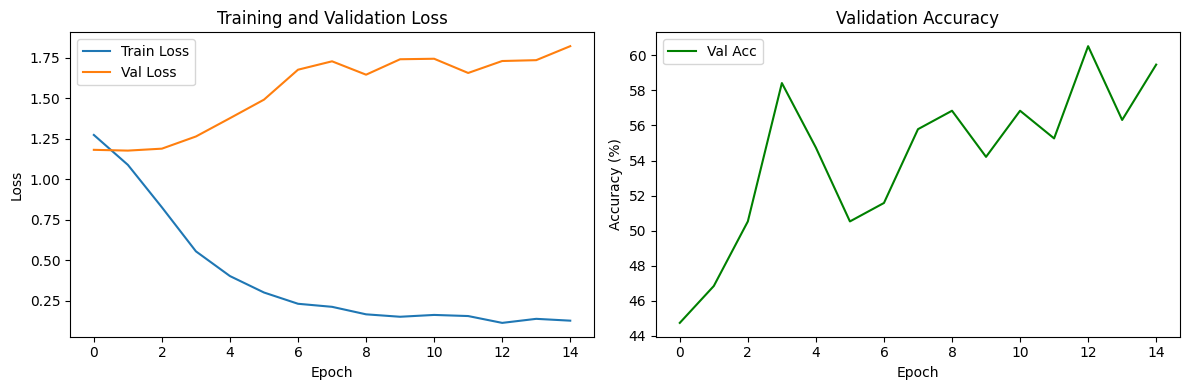


--- Test Results ---


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Evaluating: 100%|██████████| 24/24 [00:02<00:00,  9.91it/s]

Accuracy: 51.05%


In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Training Complete Summary
# Assuming val_accuracies list is populated during training
if val_accuracies:
    print(f"\nBest Val Accuracy: {max(val_accuracies):.2f}% (Epoch {np.argmax(val_accuracies)+1})")
else:
    print("\nNo validation accuracy data available to display best accuracy.")


# Plotting
plt.figure(figsize=(12, 4))

# Plotting Loss
ax1 = plt.subplot(1, 2, 1)
ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# Plotting Accuracy
ax2 = plt.subplot(1, 2, 2)
ax2.plot(val_accuracies, label='Val Acc', color='green')
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

# Evaluation Function
def evaluate(model, loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_batch = batch['label'].to(device)

            logits, _ = model(input_ids, attention_mask)
            preds = torch.argmax(logits, 1)

            # Ensure labels_batch has the same size as the actual batch size
            batch_size = input_ids.shape[0]
            labels_batch = labels_batch[:batch_size]

            correct += (preds == labels_batch).sum().item()
            total += labels_batch.size(0)
    print(f"Accuracy: {correct/total*100:.2f}%")

# Test Evaluation
print("\n--- Test Results ---")
# Assuming test_dataloader is created after data splitting
if 'test_dataloader' in locals():
    evaluate(model, test_dataloader)
else:
    print("Test dataloader not found. Please perform data splitting and create test_dataloader first.")